## Setup

In [27]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import pandas as pd
import numpy as np
import os

# To make this notebook's output stable across runs
np.random.seed(42)

# To plot the figures
import matplotlib as mlp 
import matplotlib.pyplot as plt
mlp.rc('axes', labelsize=14)
mlp.rc('xtick', labelsize=12)
mlp.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

# Function to save the figures
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, (fig_id + "." + fig_extension))
    print('Saving figure', fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Get the  data

In [28]:
DATASETS_PATH = os.path.join(PROJECT_ROOT_DIR, 'datasets')
os.makedirs(DATASETS_PATH, exist_ok=True)

DATASET_NAME = 'dados 2-4.txt'

# columns names for the dataset
columns=['Distance','RSSI']

def load_data(data_path = DATASETS_PATH, dataset_name= DATASET_NAME, columns_names=columns):
    txt_path = os.path.join(data_path, dataset_name)
    return pd.read_table(txt_path, names=columns)

# read the dataset
data_2_4_Ghz = load_data(data_path=DATASETS_PATH, dataset_name=DATASET_NAME, columns_names=columns)
data_2_4_Ghz.head()


,Distance,RSSI
0,1,-21.0
1,2,-30.0
2,3,-29.0
3,4,-33.0
4,5,-32.0


Saving figure 1-RSSIxDistance


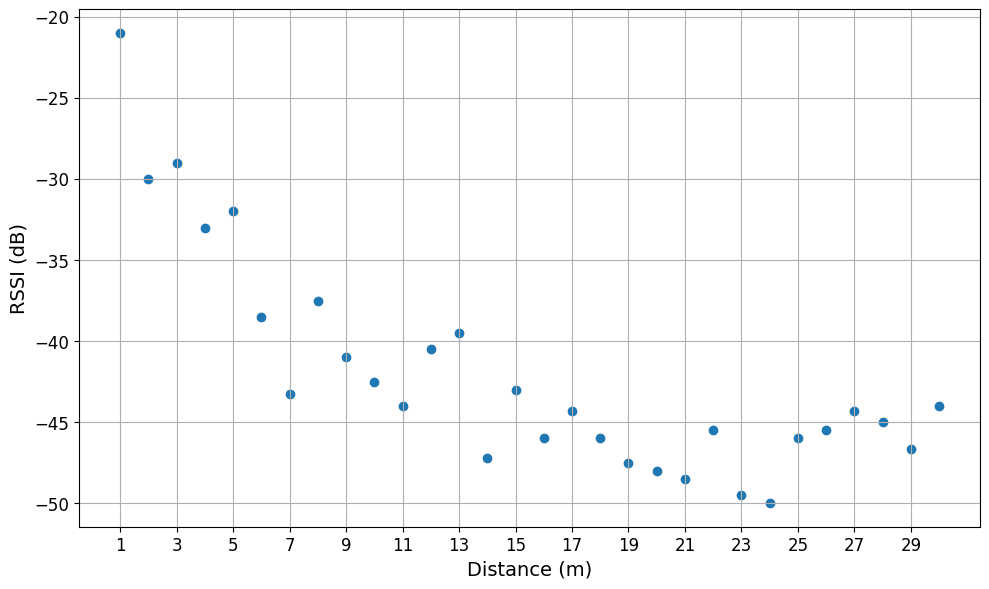

In [29]:
# Show the RSSI behavior in function of the distance
plt.figure(figsize=(10,6))
plt.scatter(data_2_4_Ghz['Distance'], data_2_4_Ghz['RSSI'], label='2.4 GHz')
plt.ylabel('RSSI (dB)')
plt.xlabel('Distance (m)')
plt.xticks(np.arange(1,30,2))
plt.grid()
save_fig('1-RSSIxDistance', fig_extension='png', resolution=300)
plt.show()

## Exploratory Data Analisys

In [30]:
import sweetviz as sv

# Analyzing the data
report = sv.analyze(data_2_4_Ghz)

# Generating the report
report.show_html('EDA/data_2_4_Ghz.html')

c:\Users\Albert\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)


Report EDA/data_2_4_Ghz.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## Prepare the data for Machine Learning algorithms

In [31]:

from sklearn.model_selection import train_test_split

# Train test split
train_set, test_set = train_test_split(data_2_4_Ghz, test_size=0.2, random_state=42)

features = train_set.drop('RSSI', axis=1)
labels = train_set['RSSI'].values

### Tranformation Pipelines

In [32]:
# Create a pipeline to preprocess the data
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

numerical_pipeline = Pipeline([
        ("standardize", StandardScaler()),
])

In [33]:
from sklearn import set_config

# Show the pipeline in diagram
set_config(display='diagram')

numerical_pipeline

Pipeline(steps=[('standardize', StandardScaler())])

In [34]:
from sklearn.compose import ColumnTransformer

# Aplication of the pipeline
preprocessing = ColumnTransformer([
    ("num", numerical_pipeline, features.columns)
])

features_prepared = preprocessing.fit_transform(features)

# Create a dataframe to visualize the data after the preprocessing (optional)
df_features_prepared = pd.DataFrame(features_prepared, columns=features.columns, index=features.index)
df_features_prepared.head(2)

,Distance
28,1.559572
24,1.113980


## Select and Train a Model

In [35]:
from sklearn.linear_model import LinearRegression

# Logistic Regression model
lin_reg = Pipeline([
    ("preprocessing", preprocessing), 
    ("linear_regression", LinearRegression())
])

lin_reg.fit(features, labels)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standardize',
                                                                   StandardScaler())]),
                                                  Index(['Distance'], dtype='object'))])),
                ('linear_regression', LinearRegression())])

In [36]:
from sklearn.tree import DecisionTreeRegressor

# Decision Tree model
tree_reg = Pipeline([
    ("preprocessing", preprocessing), 
    ("tree_regression", DecisionTreeRegressor(random_state=42))
])
tree_reg.fit(features, labels)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standardize',
                                                                   StandardScaler())]),
                                                  Index(['Distance'], dtype='object'))])),
                ('tree_regression', DecisionTreeRegressor(random_state=42))])

In [37]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = Pipeline([
    ("preprocessing", preprocessing), 
    ("random_forest", RandomForestRegressor(random_state=42))
])
forest_reg.fit(features, labels)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standardize',
                                                                   StandardScaler())]),
                                                  Index(['Distance'], dtype='object'))])),
                ('random_forest', RandomForestRegressor(random_state=42))])

### Evaluation using Cross-Validation

In [40]:
from sklearn. model_selection import cross_val_score

In [41]:
# Cross validation of the linear model
lin_rmses = -cross_val_score(lin_reg, features, labels, scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_rmses).describe()

count    10.000000
mean      4.592811
std       1.882128
min       2.284751
25%       3.077085
50%       4.454559
75%       5.689237
max       8.405435
dtype: float64

In [42]:
# Cross validation of Tree model
tree_rmses = -cross_val_score(tree_reg, features, labels, scoring="neg_root_mean_squared_error", cv =10)
pd.Series(tree_rmses).describe()

count    10.000000
mean      3.837828
std       1.600166
min       1.665893
25%       2.946939
50%       3.621595
75%       4.983466
max       6.158734
dtype: float64

In [43]:
# Cross validation of the forest model
forest_rmses = -cross_val_score(forest_reg, features, labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(forest_rmses).describe()

count    10.000000
mean     11.123991
std       9.465100
min       1.823693
25%       4.706273
50%       7.965984
75%      14.111014
max      31.314950
dtype: float64

## Fine-Tune the Model

### Randomized Search

In [44]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Function to aply the randomized search in the models
def fine_tune_model(param_distribs, model, features, labels, cv=10, n_iter=100):
    rnd_search = RandomizedSearchCV(model, param_distributions=param_distribs, n_iter=n_iter, cv=cv, scoring='neg_root_mean_squared_error', random_state=42)
    display(rnd_search.fit(features, labels))
    
    return rnd_search

#### Decision Tree Model

In [45]:
tree_param_distribs = {'tree_regression__max_features': randint(low=2, high=30), 
                  'tree_regression__min_samples_split': randint(low=2, high=10), 
                  'tree_regression__min_samples_leaf': randint(low=1, high=10),
                  'tree_regression__max_leaf_nodes': randint(low=10, high=100)}

rnd_search_tree = fine_tune_model(tree_param_distribs, tree_reg, features, labels, cv=10, n_iter=100)
tree_reg_best = rnd_search_tree.best_estimator_
tree_reg_best["tree_regression"]

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('standardize',
                                                                                                StandardScaler())]),
                                                                               Index(['Distance'], dtype='object'))])),
                                             ('tree_regression',
                                              DecisionTreeRegressor(random_state=42))]),
                   n_iter=100,
                   param_distributions={'tree_regression__max_features': <scipy.stats._distn_infrastr...
                                        'tree_regression__max_leaf_nodes': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001FD91866850>,
                                        'tree_regression__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001FD91871190>,
                                        'tree_regression__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001FD91872D50>},
                   random_state=42, scoring='neg_root_mean_squared_error')

DecisionTreeRegressor(max_features=28, max_leaf_nodes=36, min_samples_leaf=2,
                      min_samples_split=6, random_state=42)

#### Random Forest Model

In [46]:
forest_param_distribs = {'random_forest__n_estimators': randint(low=1, high=200), 
                  'random_forest__min_samples_split': randint(low=2, high=10), 
                  'random_forest__min_samples_leaf': randint(low=1, high=10),
                  'random_forest__max_leaf_nodes': randint(low=10, high=100)}

rnd_search_forest = fine_tune_model(forest_param_distribs, forest_reg, features, labels, cv=10, n_iter=100)
forest_reg_best = rnd_search_forest.best_estimator_
forest_reg_best["random_forest"]

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('standardize',
                                                                                                StandardScaler())]),
                                                                               Index(['Distance'], dtype='object'))])),
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   n_iter=100,
                   param_distributions={'random_forest__max_leaf_nodes': <scipy.stats._distn_infrastruc...
                                        'random_forest__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001FD91544890>,
                                        'random_forest__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001FD878C4450>,
                                        'random_forest__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001FD916FE4D0>},
                   random_state=42, scoring='neg_root_mean_squared_error')

RandomForestRegressor(max_leaf_nodes=27, min_samples_leaf=2,
                      min_samples_split=3, n_estimators=190, random_state=42)

## Evaluate the Model on the Test Set

In [47]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

# The test set
X_test = test_set.drop('RSSI', axis=1)
y_test = test_set['RSSI'].copy()

### Linear Model Test

In [48]:
# Linear model prediction in the test set
lin_reg_prediction = lin_reg.predict(X_test)

# RSME, MAE and R2 of the linear model
lin_reg_rmse = root_mean_squared_error(y_test, lin_reg_prediction)
lin_reg_mae = mean_absolute_error(y_test, lin_reg_prediction)
lin_reg_r2 = r2_score(y_test, lin_reg_prediction)

print(f'RSME ({lin_reg.named_steps["linear_regression"].__class__.__name__}): {lin_reg_rmse}')
print(f'MAE ({lin_reg.named_steps["linear_regression"].__class__.__name__}): {lin_reg_mae}')
print(f'R2 ({lin_reg.named_steps["linear_regression"].__class__.__name__}): {lin_reg_r2}')

RSME (LinearRegression): 3.8573790005157824
MAE (LinearRegression): 3.8032055038492474
R2 (LinearRegression): -0.8142503611526668


### Decision Tree Model Test

In [49]:
# Decision Tree prediction in the test set
tree_reg_prediction = tree_reg_best.predict(X_test)

# RSME, MAE and R2 of the Decision Tree model
tree_reg_rmse = root_mean_squared_error(y_test, tree_reg_prediction)
tree_reg_mae = mean_absolute_error(y_test, tree_reg_prediction)
tree_reg_r2 = r2_score(y_test, tree_reg_prediction)

print(f'RSME ({tree_reg_best.named_steps["tree_regression"].__class__.__name__}): {tree_reg_rmse}')
print(f'MAE ({tree_reg_best.named_steps["tree_regression"].__class__.__name__}): {tree_reg_mae}')
print(f'R2 ({tree_reg_best.named_steps["tree_regression"].__class__.__name__}): {tree_reg_r2}') 

RSME (DecisionTreeRegressor): 1.4393455045545807
MAE (DecisionTreeRegressor): 1.3118888888888887
R2 (DecisionTreeRegressor): 0.7473945560259668


### Random Forest Model Test

In [50]:
# Random Forest Model prediction in the test set
forest_reg_prediction = forest_reg_best.predict(X_test)

# RSME, MAE and R2 of the Random Forest model
forest_reg_rmse = root_mean_squared_error(y_test, forest_reg_prediction)
forest_reg_mae = mean_absolute_error(y_test, forest_reg_prediction)
forest_reg_r2 = r2_score(y_test, forest_reg_prediction)

print(f'RSME ({forest_reg_best.named_steps["random_forest"].__class__.__name__}): {forest_reg_rmse}')
print(f'MAE ({forest_reg_best.named_steps["random_forest"].__class__.__name__}): {forest_reg_mae}')
print(f'R2 ({forest_reg_best.named_steps["random_forest"].__class__.__name__}): {forest_reg_r2}')

RSME (RandomForestRegressor): 1.4781908911594612
MAE (RandomForestRegressor): 1.2213335317460274
R2 (RandomForestRegressor): 0.7335758198630149


In [51]:
from scipy import stats

# Confidence interval (95%)

confidence = 0.95
squared_errors = (tree_reg_prediction - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([0.54704307, 1.96065674])

In [86]:
# Plot the R2

def plot_r2(y_test, model_prediction, model_name, color='blue'):
    
    # Values of the RSSI to create the line of the R2=1 which is the ideal value
    rssi_values = np.linspace(-55, -20, 30)
    
    figure = plt.figure(figsize=(10,6))
    plt.scatter(y_test, model_prediction, marker='o', s=30, color=color, label=model_name)
    plt.plot(rssi_values, rssi_values, color='black', linestyle='--', label=r'$R^2=1$ (Caso ideal)')
    plt.xlabel('RSSI real', fontsize=15)
    plt.ylabel('RSSI previsto', fontsize=15)
    plt.legend(loc='best', fontsize=13)
    plt.xlim(-55, -20)
    plt.ylim(-55, -20)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.grid()
    plt.show()

    return figure

## Model Persistence using Joblib

In [54]:
import joblib

def save_model(model, model_name):
    MODEL_PATH = os.path.join(PROJECT_ROOT_DIR, 'models', model_name)
    joblib.dump(model, MODEL_PATH)

# Save the linear model
save_model(lin_reg, 'lin_reg.pkl')
# Save the Decision Tree model
save_model(tree_reg_best, 'tree_reg_best.pkl')
# Save the Random Forest model
save_model(forest_reg_best, 'forest_reg_best.pkl')

## RSSI Calculate with Optmized Path Loss Equation 

In [55]:
# Frequency
frequency = 2412
# Transmit power
Pt = 10 * np.log10(250) + 5 + 1
# Reference distance
d0 = 1

# Free-space path loss model
Ao = 32.44+20*np.log10(d0/1000)+20*np.log10(frequency)
# Distances
d = X_test.values
# d = X_test.values[-1]

# Obtem apenas a ultima amostra do dataset X_test


# Optimized coefficients
n = 1.7143
k = 13.3156

# Optimized Path Loss
L = Ao + 10*n*np.log10(d/d0) + k

# Received Power According to the Optimized Path Loss
Pr = Pt - L

print(Pr)

[[-48.23237611]
 [-44.06597485]
 [-47.0847073 ]
 [-44.94288254]
 [-39.78232532]
 [-40.56674598]]


### Analyzing the Metrics of Optimized Path Loss Equation

In [56]:
# R^2 and RMSE of the optimized path loss
path_loss_opt_rmse = root_mean_squared_error(Pr, y_test)
path_loss_opt_r2 = r2_score(Pr, y_test)

print(path_loss_opt_rmse)
print(path_loss_opt_r2)

2.199444635133243
0.4980215017973775
